# **Time-series Forecasting of Stock Market**

# Project Objective & Workflow 

The objective of this project is to create a model that can forecast the next
month of Close price.
here are the steps that need to be done:


1.    **Data wrangling and preprocessing** 
    * Handle Mising Values: Calculate the number of missing values & Impute the missing values.
    * Handling Categorical Values: Express each variable as a numerical value (all data is originally stored as strings).
    * Resample the data by month.


2.  **Feature engineering**
    * Identify any seasonality (Yearly,Monthly)
    * Split the DateTime object into Month and Year columns.
    * Scale the data

3. **Split the data**
    * Make a 70:20:10 split to create training, validation, and test sets.

4. **Prepare for deep learning modeling**
    * Implement the DataWindow class.
    * Define the compile_and_fit function.
    * Create a dictionary of column indices and column names.

5. **Model with deep learning**
    * **Train two baseline model.** 
    * **Train a linear model.** 
    * **Train a deep neural network.**  
    * **Train an LSTM.** 
    * **Train a CNN.** 
    * **Train a combination of LSTM and CNN.** 
    * **Train an autoregressive LSTM.** 
    * Select the best-performing model.

# Libs & APIs


In [241]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns

import datetime

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [242]:
plt.rcParams['figure.figsize'] = (10, 4)

In [243]:
tf.random.set_seed(42)
np.random.seed(42)

In [244]:
url = "../input/stock-market-data/stock_market_data/nasdaq/csv/AAL.csv"
_df =pd.read_csv(url,sep=',')
len(_df)

4333

In [245]:
# copy data
df= _df.copy()

df.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,27-09-2005,19.100000,21.049999,961200,21.400000,19.299999,18.194910
1,28-09-2005,19.200001,19.299999,5747900,20.530001,20.500000,19.326204
2,29-09-2005,20.100000,20.400000,1078200,20.580000,20.209999,19.052805
3,30-09-2005,20.180000,20.260000,3123300,21.049999,21.010000,19.807001
4,03-10-2005,20.900000,20.900000,1057900,21.750000,21.500000,20.268940


In [246]:
df.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,27-09-2005,19.100000,21.049999,961200,21.400000,19.299999,18.194910
1,28-09-2005,19.200001,19.299999,5747900,20.530001,20.500000,19.326204
2,29-09-2005,20.100000,20.400000,1078200,20.580000,20.209999,19.052805
3,30-09-2005,20.180000,20.260000,3123300,21.049999,21.010000,19.807001
4,03-10-2005,20.900000,20.900000,1057900,21.750000,21.500000,20.268940


In [247]:
df.tail()

,Date,Low,Open,Volume,High,Close,Adjusted Close
4328,06-12-2022,14.00,14.14,20781500,14.34,14.330,14.330
4329,07-12-2022,13.53,14.24,28161400,14.24,13.550,13.550
4330,08-12-2022,13.38,13.65,25300900,13.80,13.600,13.600
4331,09-12-2022,13.42,13.52,18489800,13.66,13.530,13.530
4332,12-12-2022,13.45,13.49,8048550,13.93,13.915,13.915


In [248]:
df.shape

(4333, 7)

In [249]:
df.isna().sum()

Date              0
Low               0
Open              0
Volume            0
High              0
Close             0
Adjusted Close    0
dtype: int64

In [250]:
df.dtypes

Date               object
Low               float64
Open              float64
Volume              int64
High              float64
Close             float64
Adjusted Close    float64
dtype: object

In [251]:
df['Date'] = pd.to_datetime(df['Date'])

In [252]:
days_per_month = df.groupby(df['Date'].dt.to_period('M'))['Date'].nunique()
days_per_month = pd.DataFrame(days_per_month)
days_per_month.head(20)

,Date
Date,
2005-09,4
2005-10,21
2005-11,21
2005-12,21
2006-01,20
2006-02,19
2006-03,23
2006-04,19
2006-05,22


In [253]:

df = df[df['Date'].dt.year != 2005]

df.reset_index(inplace = True, drop = True)

df.head(5)

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,2006-01-03,36.849998,37.200001,1013200,38.279999,37.450001,35.305672
1,2006-01-04,37.700001,37.700001,1928400,40.599998,39.200001,36.955467
2,2006-01-05,38.910000,39.180000,317900,39.709999,39.709999,37.436268
3,2006-01-06,38.139999,39.709999,349200,39.709999,39.000000,36.766914
4,2006-01-09,38.500000,38.799999,220800,38.880001,38.610001,36.399242


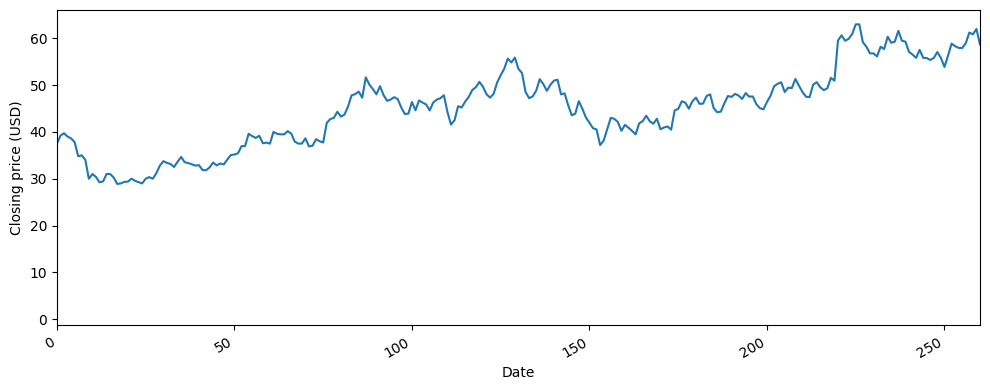

In [254]:
fig, ax = plt.subplots(figsize=(10,4))

ax.plot(df['Close'])
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (USD)')

ax.set_xlim(0, 260)

fig.autofmt_xdate()
plt.tight_layout()

In [255]:
df.to_csv('../clean_AAL.csv', header=True, index=False)

In [256]:
df = pd.read_csv('../clean_AAL.csv')
df.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,2006-01-03,36.849998,37.200001,1013200,38.279999,37.450001,35.305672
1,2006-01-04,37.700001,37.700001,1928400,40.599998,39.200001,36.955467
2,2006-01-05,38.910000,39.180000,317900,39.709999,39.709999,37.436268
3,2006-01-06,38.139999,39.709999,349200,39.709999,39.000000,36.766914
4,2006-01-09,38.500000,38.799999,220800,38.880001,38.610001,36.399242


In [257]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Low,4266.0,2.488723e+01,1.580789e+01,1.450000,1.053500e+01,2.133500e+01,3.914000e+01,6.200000e+01
Open,4266.0,2.538824e+01,1.600633e+01,1.810000,1.082250e+01,2.189000e+01,3.974500e+01,6.270000e+01
Volume,4266.0,1.458939e+07,2.207456e+07,191300.000000,4.749500e+06,7.557550e+06,1.352832e+07,4.286171e+08
High,4266.0,2.585412e+01,1.619366e+01,2.030000,1.111250e+01,2.224000e+01,4.029750e+01,6.327000e+01
Close,4266.0,2.535673e+01,1.600430e+01,1.760000,1.079250e+01,2.181500e+01,3.970500e+01,6.295000e+01
Adjusted Close,4266.0,2.439955e+01,1.533443e+01,1.659225,1.024113e+01,2.143500e+01,3.797598e+01,5.934557e+01


In [258]:
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

monthly_mean = df.groupby([ 'Month'])['Close'].mean().reset_index()

yearly_mean = df.groupby([ 'Year'])['Close'].mean().reset_index()

In [259]:
monthly_mean

,Month,Close
0,1,27.501545
1,2,27.312301
2,3,26.263324
3,4,25.501880
4,5,25.268106
5,6,24.701071
6,7,24.789972
7,8,23.683342
8,9,23.654870
9,10,24.397701


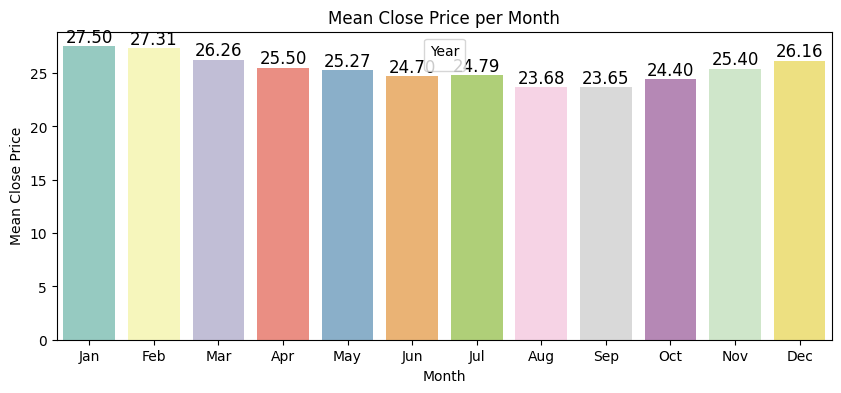

In [260]:
ax =sns.barplot(data=monthly_mean, x='Month', y='Close',  palette='Set3')

plt.title('Mean Close Price per Month')
plt.xlabel('Month')
plt.ylabel('Mean Close Price')

plt.xticks(range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year')


for bars in ax.containers:
     ax.bar_label(bars, fontsize=12, fmt='%.2f')
plt.show()

In [261]:
yearly_mean.head()

,Year,Close
0,2006,44.322390
1,2007,35.671952
2,2008,7.742134
3,2009,3.829643
4,2010,8.636667


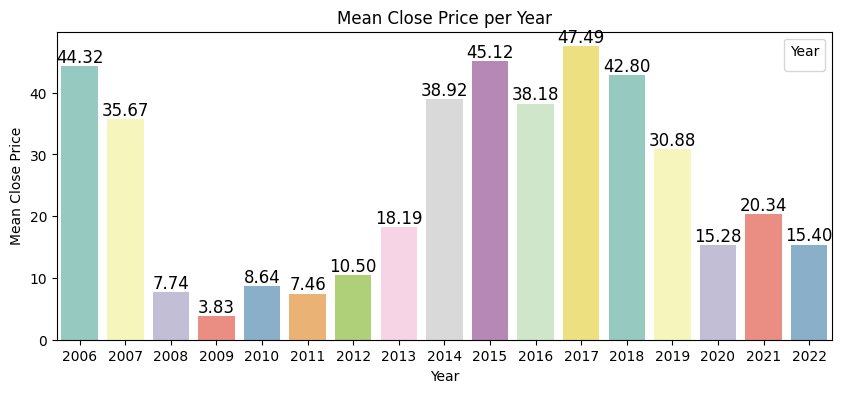

In [262]:
lst_year= yearly_mean['Year'].tolist()

ax = sns.barplot(data=yearly_mean, x='Year', y='Close',  palette='Set3')

plt.title('Mean Close Price per Year')
plt.xlabel('Year')
plt.ylabel('Mean Close Price')

plt.xticks(range(0, len(lst_year)), labels=lst_year)
plt.legend(title='Year')

for bars in ax.containers:
     ax.bar_label(bars, fontsize=12, fmt='%.2f')

plt.show()

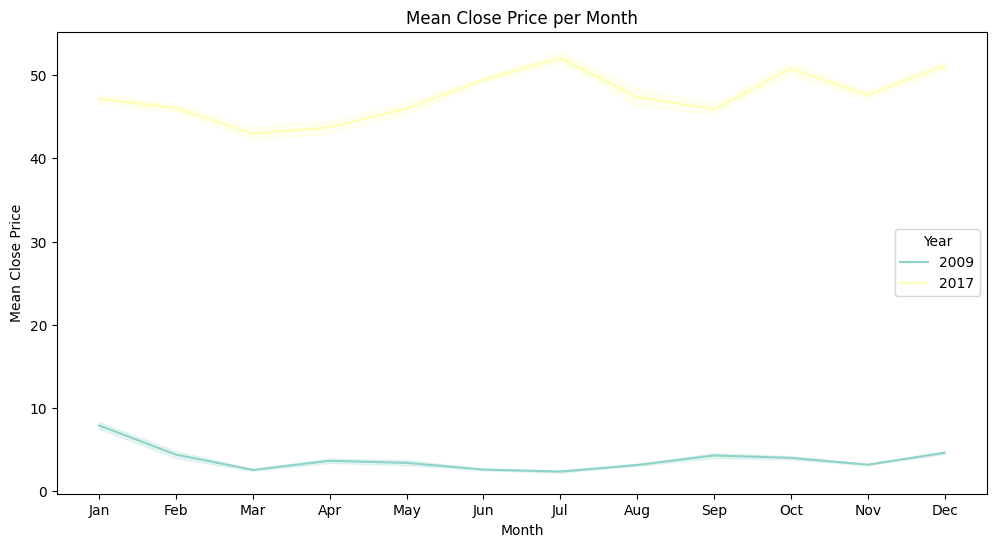

In [263]:
plt.figure(figsize=(12, 6))

filtered_df = df[df['Year'].isin([2009,2017])]
sns.lineplot(data=filtered_df, x='Month', y='Close', hue='Year', palette='Set3')

plt.title('Mean Close Price per Month')

plt.xlabel('Month')
plt.ylabel('Mean Close Price')

plt.xticks(range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.legend(title='Year')
plt.show()

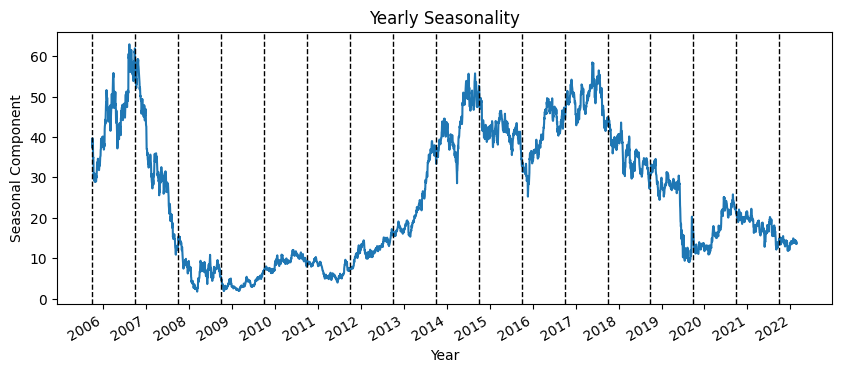

<Figure size 1000x500 with 0 Axes>

In [264]:
fig, ax = plt.subplots()

ax.plot(df['Close'])
for i in np.arange(0, len(df), 260):
    ax.axvline(x=i, linestyle='--', color='black', linewidth=1)

plt.title('Yearly Seasonality')
plt.xlabel('Year')
plt.ylabel('Seasonal Component')

plt.xticks(np.arange(67, len(df), 260), np.arange(2006, 2023, 1))

plt.figure(figsize=(10, 5))

fig.autofmt_xdate()
plt.tight_layout()

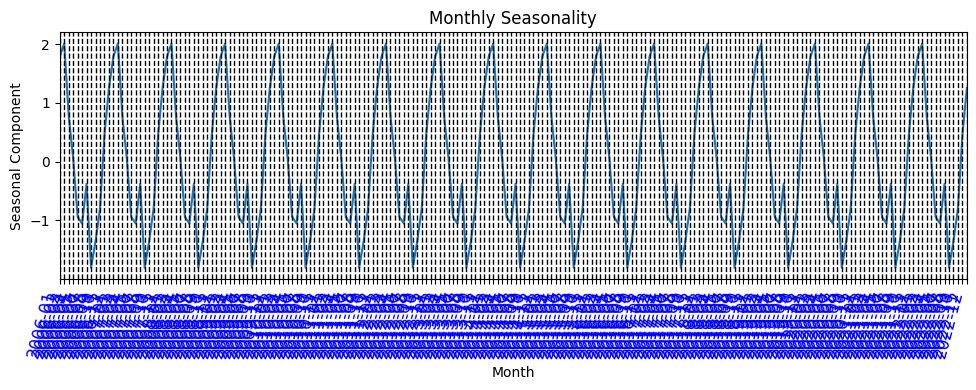

In [265]:

import statsmodels.api as sm

df_seasonality = df.copy()

df_seasonality.set_index('Date', inplace=True)

monthly_data = df_seasonality['Close'].resample('M').mean()

month_numbers = pd.to_datetime(monthly_data.index).strftime('%m')

df_monthly_data= monthly_data.to_frame(name="Close")
df_monthly_data['month_numbers'] = month_numbers

decomposition = sm.tsa.seasonal_decompose(monthly_data, model='additive')

fig, ax = plt.subplots()

decomposition.seasonal.plot(ax=ax)

times = np.arange('2006-01', '2023-01', dtype='datetime64[M]')
ax.set_xticks(times)

for i in np.arange(0, len(df), 1):
    ax.axvline(x=i, linestyle='--', color='black', linewidth=1)

plt.title('Monthly Seasonality' ,  fontsize = 12)
plt.xlabel('Month',  fontsize = 10)
plt.ylabel('Seasonal Component',fontsize = 10)

plt.rcParams['figure.figsize'] = (30, 10)

fig.autofmt_xdate()
ax.set_xticklabels(times,rotation = 75,
                   ha = 'right', fontsize = 12,
                   color = 'blue')

plt.tight_layout()
plt.show()

In [266]:
df.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close,Month,Year
0,2006-01-03,36.849998,37.200001,1013200,38.279999,37.450001,35.305672,1,2006
1,2006-01-04,37.700001,37.700001,1928400,40.599998,39.200001,36.955467,1,2006
2,2006-01-05,38.910000,39.180000,317900,39.709999,39.709999,37.436268,1,2006
3,2006-01-06,38.139999,39.709999,349200,39.709999,39.000000,36.766914,1,2006
4,2006-01-09,38.500000,38.799999,220800,38.880001,38.610001,36.399242,1,2006


In [267]:
cols_to_drop = ['Date']
df = df.drop(cols_to_drop, axis=1)

df.head()



,Low,Open,Volume,High,Close,Adjusted Close,Month,Year
0,36.849998,37.200001,1013200,38.279999,37.450001,35.305672,1,2006
1,37.700001,37.700001,1928400,40.599998,39.200001,36.955467,1,2006
2,38.910000,39.180000,317900,39.709999,39.709999,37.436268,1,2006
3,38.139999,39.709999,349200,39.709999,39.000000,36.766914,1,2006
4,38.500000,38.799999,220800,38.880001,38.610001,36.399242,1,2006


In [268]:
n = len(df)

train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

Next, we’ll fit the scaler to the training set only, and scale each individual set.

In [269]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_df)

train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

**Save Data**

We can save each set to be used later for modeling.

In [270]:
train_df.to_csv('../train.csv', index=False, header=True)
val_df.to_csv('../val.csv', index=False, header=True)
test_df.to_csv('../test.csv', index=False, header=True)

In [271]:
train_df = pd.read_csv('../train.csv')
val_df = pd.read_csv('../val.csv')
test_df = pd.read_csv('../test.csv')

In [272]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

In [273]:
class DataWindow():

  def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):

            self.train_df = train_df
            self.val_df = val_df
            self.test_df = test_df

            self.label_columns = label_columns
            if label_columns is not None:
                self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
            self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

            self.input_width = input_width
            self.label_width = label_width
            self.shift = shift

            self.total_window_size = input_width + shift

            self.input_slice = slice(0, input_width)

            self.input_indices = np.arange(self.total_window_size)[self.input_slice]

            self.label_start = self.total_window_size - self.label_width
            self.labels_slice = slice(self.label_start, None)
            self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def split_to_inputs_labels(self, features):
            inputs = features[:, self.input_slice, :]
            labels = features[:, self.labels_slice, :]

            if self.label_columns is not None:
                labels = tf.stack(
                    [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                    axis=-1
                )
            inputs.set_shape([None, self.input_width, None])
            labels.set_shape([None, self.label_width, None])

            return inputs, labels

  def plot(self, model=None, plot_col='Close', max_subplots=3):
            inputs, labels = self.sample_batch

            plt.figure(figsize=(12, 8))
            plot_col_index = self.column_indices[plot_col]
            max_n = min(max_subplots, len(inputs))
            
            for n in range(max_n):
                plt.subplot(3, 1, n+1)
                plt.ylabel(f'{plot_col} [scaled]')
                plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                        label='Inputs', marker='.', zorder=-10)

                if self.label_columns:
                  label_col_index = self.label_columns_indices.get(plot_col, None)
                else:
                  label_col_index = plot_col_index

                if label_col_index is None:
                  continue

                plt.scatter(self.label_indices, labels[n, :, label_col_index],
                            edgecolors='k', marker='s', label='Labels', c='green', s=64)
                if model is not None:
                  predictions = model(inputs)
                
                  plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                              marker='X', edgecolors='k', label='Predictions',
                              c='red', s=64)

                if n == 0:
                  plt.legend()

            plt.xlabel('Date (Day)')
            plt.ylabel('Closing price (USD)')

  def make_dataset(self, data):
            data = np.array(data, dtype=np.float32)
            ds = tf.keras.preprocessing.timeseries_dataset_from_array(
                data=data,
                targets=None,
                sequence_length=self.total_window_size,
                sequence_stride=1,
                shuffle=True,
                batch_size=32
            )

            ds = ds.map(self.split_to_inputs_labels)
            return ds

  @property
  def train(self):
      return self.make_dataset(self.train_df)

  @property
  def val(self):
      return self.make_dataset(self.val_df)

  @property
  def test(self):
      return self.make_dataset(self.test_df)

  @property
  def sample_batch(self):
      result = getattr(self, '_sample_batch', None)
      if result is None:
          result = next(iter(self.train))
          self._sample_batch = result
      return result

In [274]:
def compile_and_fit(model, window, patience=3, max_epochs=50):

    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')

    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()]) 
    history = model.fit(window.train,
                       epochs=max_epochs,   
                       validation_data=window.val,
                       callbacks=[early_stopping]) 

    return history

In [275]:
multi_window = DataWindow(input_width=21, label_width=21, shift=21,label_columns=['Close'])

In [276]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 21, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 21, 1])

In [277]:
baseline_last = MultiStepLastBaseline(label_index=column_indices['Close'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(multi_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(multi_window.test, verbose=0)

26/26 [==============================] - 0s 3ms/step - loss: 0.2019 - mean_absolute_error: 0.2921


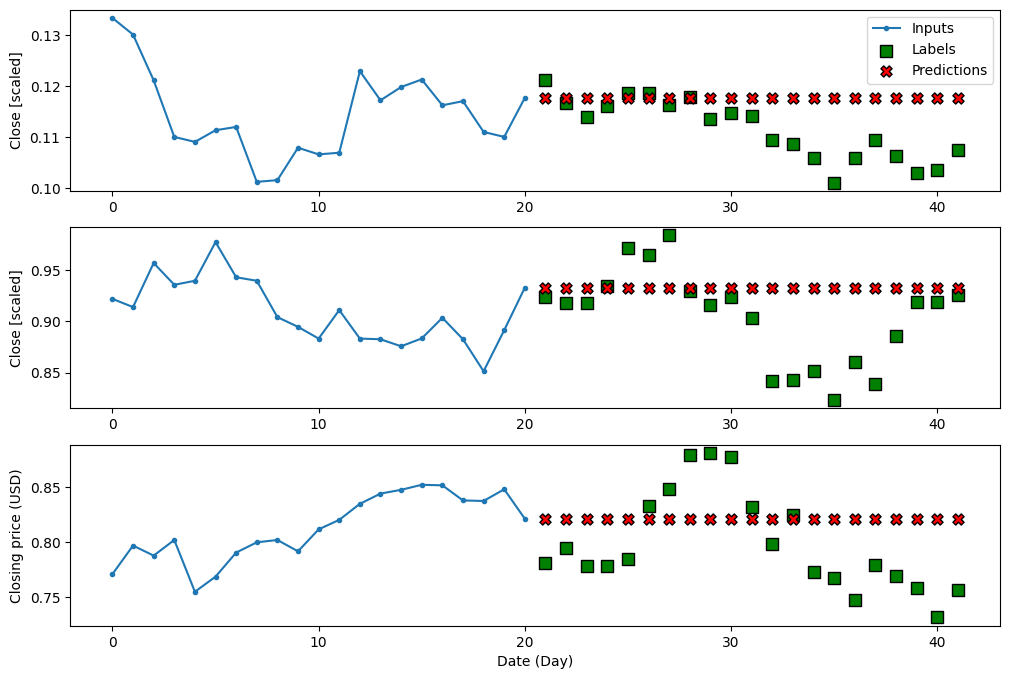

In [278]:
multi_window.plot(baseline_last)

In [279]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [280]:
baseline_repeat = RepeatBaseline(label_index=column_indices['Close'])

baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.val)
performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.test, verbose=0)

26/26 [==============================] - 0s 2ms/step - loss: 0.2003 - mean_absolute_error: 0.2977


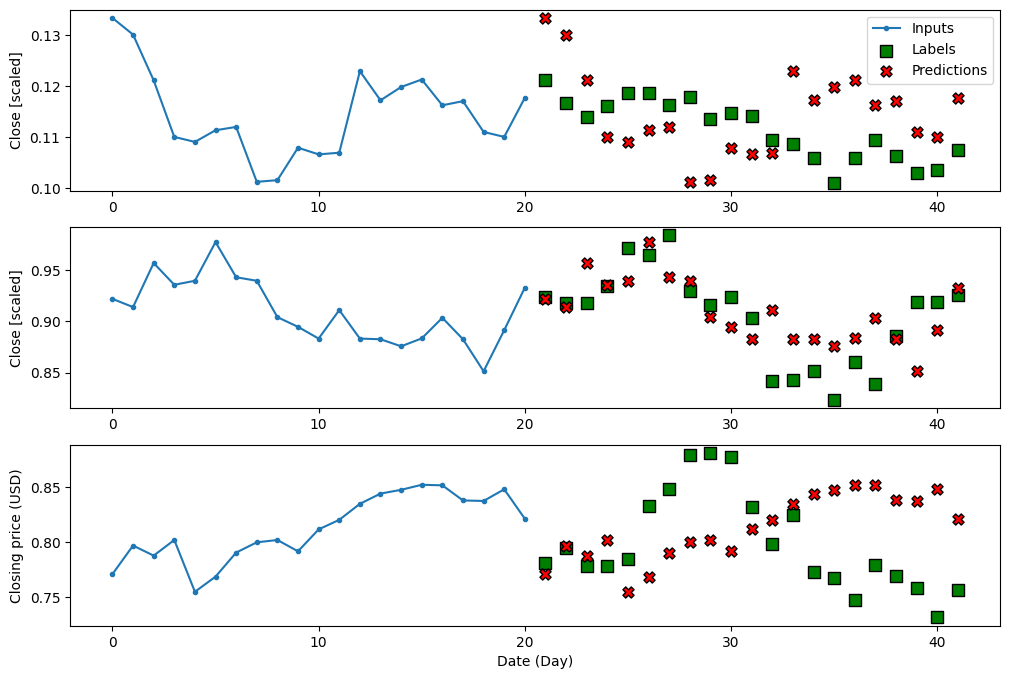

In [281]:
multi_window.plot(baseline_repeat)

In [282]:
label_index = column_indices['Close']
num_features = train_df.shape[1]

linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

In [283]:
history = compile_and_fit(linear, multi_window)

val_performance['Linear'] = linear.evaluate(multi_window.val)
performance['Linear'] = linear.evaluate(multi_window.test, verbose=0)

Epoch 1/50
93/93 [==============================] - 1s 5ms/step - loss: 0.1100 - mean_absolute_error: 0.2474 - val_loss: 0.0273 - val_mean_absolute_error: 0.1390
Epoch 2/50
93/93 [==============================] - 0s 4ms/step - loss: 0.0238 - mean_absolute_error: 0.1309 - val_loss: 0.0206 - val_mean_absolute_error: 0.1145
Epoch 3/50
93/93 [==============================] - 0s 4ms/step - loss: 0.0138 - mean_absolute_error: 0.1021 - val_loss: 0.0175 - val_mean_absolute_error: 0.1061
Epoch 4/50
93/93 [==============================] - 0s 4ms/step - loss: 0.0097 - mean_absolute_error: 0.0846 - val_loss: 0.0134 - val_mean_absolute_error: 0.0934
Epoch 5/50
93/93 [==============================] - 0s 4ms/step - loss: 0.0069 - mean_absolute_error: 0.0703 - val_loss: 0.0102 - val_mean_absolute_error: 0.0816
Epoch 6/50
93/93 [==============================] - 0s 4ms/step - loss: 0.0053 - mean_absolute_error: 0.0594 - val_loss: 0.0084 - val_mean_absolute_error: 0.0729
Epoch 7/50
93/93 [==========

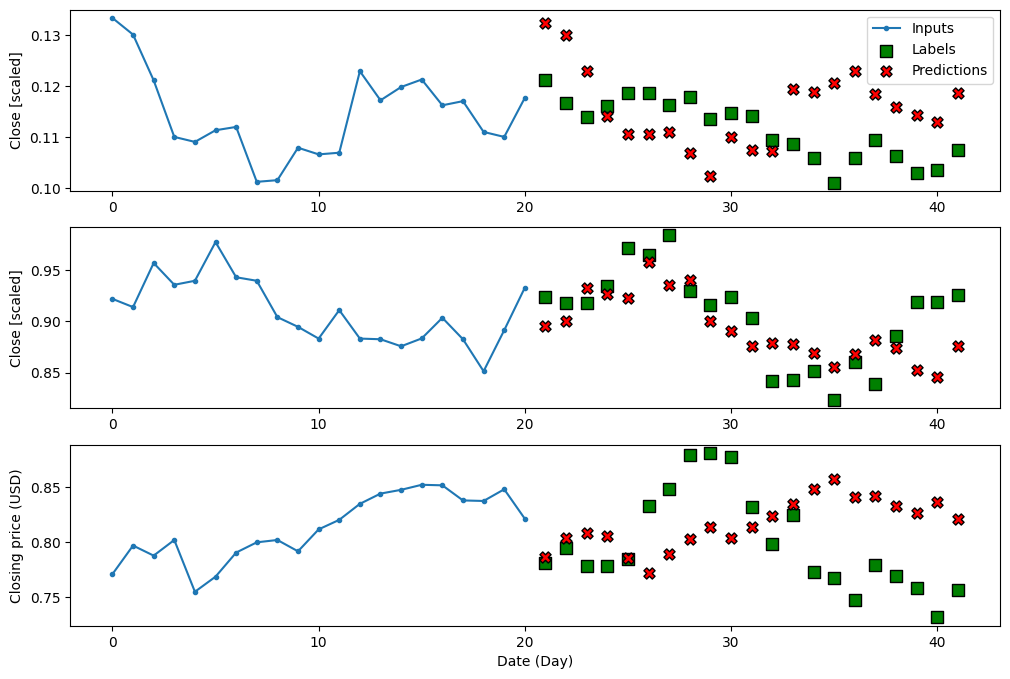

In [284]:
multi_window.plot(linear)

In [285]:
dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(dense, multi_window)

val_performance['Dense'] = dense.evaluate(multi_window.val)
performance['Dense'] = dense.evaluate(multi_window.test, verbose=0)

Epoch 1/50
93/93 [==============================] - 2s 8ms/step - loss: 0.0466 - mean_absolute_error: 0.1360 - val_loss: 0.0048 - val_mean_absolute_error: 0.0523
Epoch 2/50
93/93 [==============================] - 1s 7ms/step - loss: 0.0034 - mean_absolute_error: 0.0425 - val_loss: 0.0051 - val_mean_absolute_error: 0.0558
Epoch 3/50
93/93 [==============================] - 1s 5ms/step - loss: 0.0031 - mean_absolute_error: 0.0406 - val_loss: 0.0090 - val_mean_absolute_error: 0.0756
Epoch 4/50
26/26 [==============================] - 0s 3ms/step - loss: 0.0074 - mean_absolute_error: 0.0685


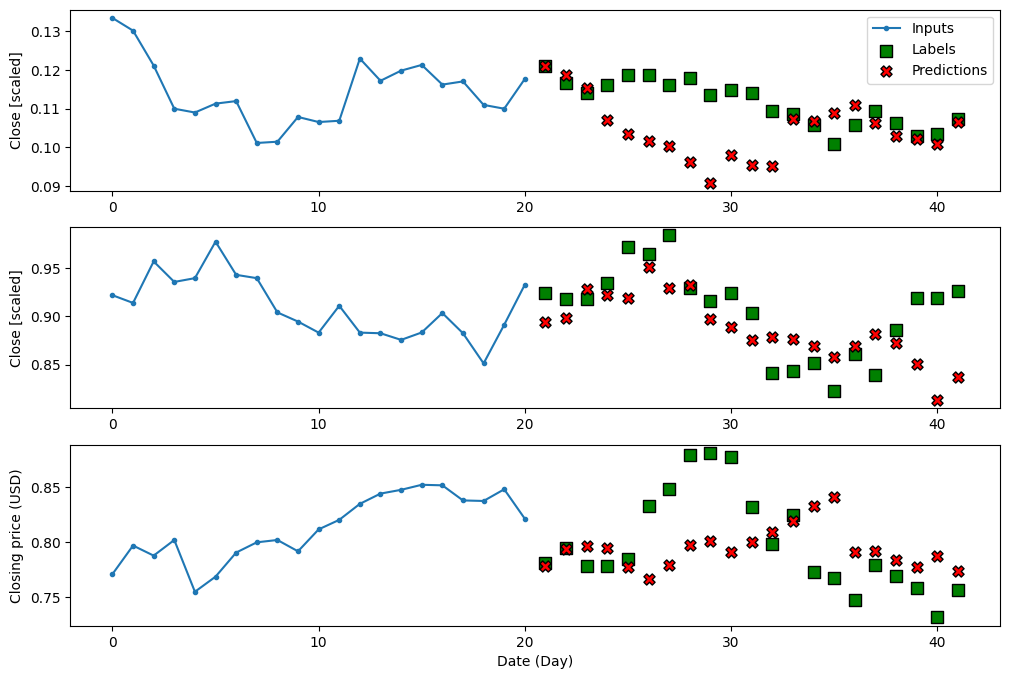

In [286]:
multi_window.plot(dense)

In [287]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(lstm_model, multi_window)

val_performance['LSTM'] = lstm_model.evaluate(multi_window.val)
performance['LSTM'] = lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
93/93 [==============================] - 4s 19ms/step - loss: 0.0626 - mean_absolute_error: 0.1627 - val_loss: 0.0150 - val_mean_absolute_error: 0.0857
Epoch 2/50
93/93 [==============================] - 1s 14ms/step - loss: 0.0101 - mean_absolute_error: 0.0646 - val_loss: 0.0122 - val_mean_absolute_error: 0.0819
Epoch 3/50
93/93 [==============================] - 1s 13ms/step - loss: 0.0068 - mean_absolute_error: 0.0555 - val_loss: 0.0106 - val_mean_absolute_error: 0.0783
Epoch 4/50
93/93 [==============================] - 1s 14ms/step - loss: 0.0054 - mean_absolute_error: 0.0513 - val_loss: 0.0078 - val_mean_absolute_error: 0.0658
Epoch 5/50
93/93 [==============================] - 1s 14ms/step - loss: 0.0045 - mean_absolute_error: 0.0477 - val_loss: 0.0077 - val_mean_absolute_error: 0.0670
Epoch 6/50
93/93 [==============================] - 1s 15ms/step - loss: 0.0039 - mean_absolute_error: 0.0455 - val_loss: 0.0089 - val_mean_absolute_error: 0.0745
Epoch 7/50
93/93 [====

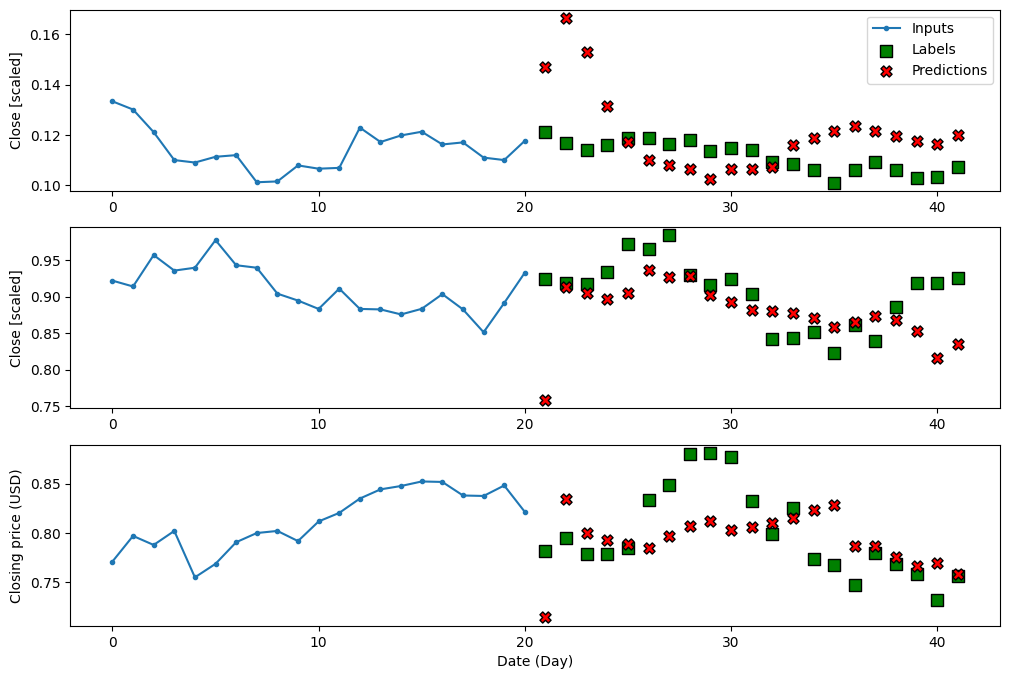

In [288]:
multi_window.plot(lstm_model)

In [289]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 21
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

In [290]:
cnn_multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=21, label_columns=['Close'])

In [291]:
cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_model, cnn_multi_window)

val_performance['CNN'] = cnn_model.evaluate(cnn_multi_window.val)
performance['CNN'] = cnn_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/50
92/92 [==============================] - 2s 6ms/step - loss: 0.0479 - mean_absolute_error: 0.1447 - val_loss: 0.0058 - val_mean_absolute_error: 0.0591
Epoch 2/50
92/92 [==============================] - 0s 5ms/step - loss: 0.0035 - mean_absolute_error: 0.0434 - val_loss: 0.0057 - val_mean_absolute_error: 0.0569
Epoch 3/50
92/92 [==============================] - 1s 6ms/step - loss: 0.0034 - mean_absolute_error: 0.0424 - val_loss: 0.0070 - val_mean_absolute_error: 0.0652
Epoch 4/50
92/92 [==============================] - 0s 5ms/step - loss: 0.0033 - mean_absolute_error: 0.0419 - val_loss: 0.0060 - val_mean_absolute_error: 0.0607
Epoch 5/50
26/26 [==============================] - 0s 2ms/step - loss: 0.0071 - mean_absolute_error: 0.0667


We can now visualize the predictions.


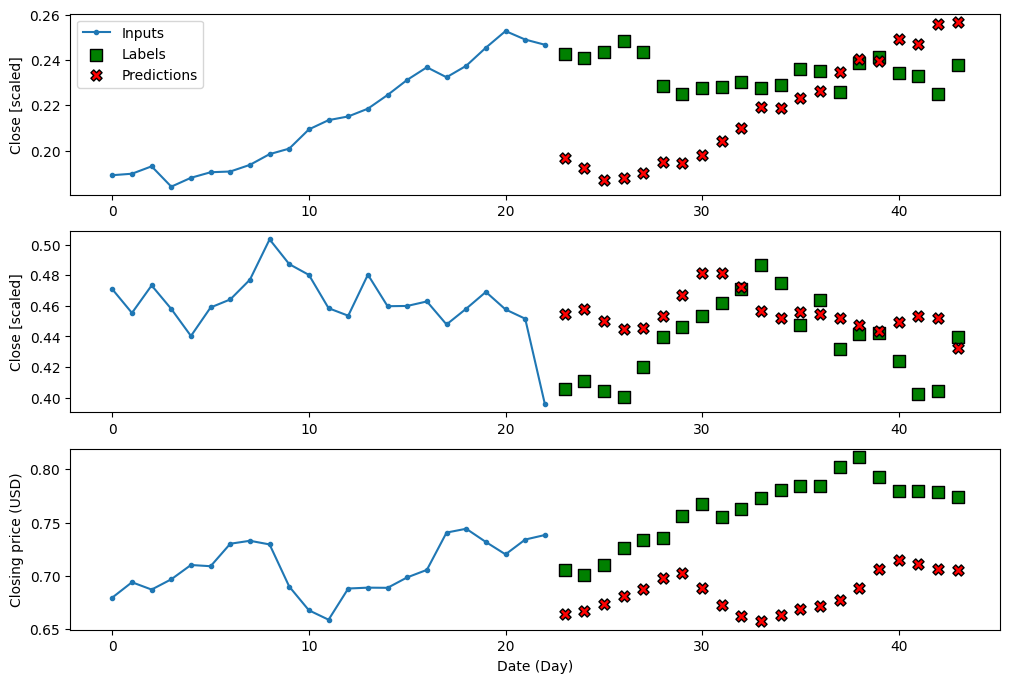

In [292]:
cnn_multi_window.plot(cnn_model)

In [293]:
cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])


In [294]:

history = compile_and_fit(cnn_lstm_model, cnn_multi_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/50
92/92 [==============================] - 5s 22ms/step - loss: 0.0493 - mean_absolute_error: 0.1414 - val_loss: 0.0096 - val_mean_absolute_error: 0.0715
Epoch 2/50
92/92 [==============================] - 1s 15ms/step - loss: 0.0053 - mean_absolute_error: 0.0514 - val_loss: 0.0076 - val_mean_absolute_error: 0.0659
Epoch 3/50
92/92 [==============================] - 2s 17ms/step - loss: 0.0040 - mean_absolute_error: 0.0464 - val_loss: 0.0088 - val_mean_absolute_error: 0.0738
Epoch 4/50
92/92 [==============================] - 2s 17ms/step - loss: 0.0035 - mean_absolute_error: 0.0436 - val_loss: 0.0070 - val_mean_absolute_error: 0.0655
Epoch 5/50
92/92 [==============================] - 2s 16ms/step - loss: 0.0033 - mean_absolute_error: 0.0423 - val_loss: 0.0093 - val_mean_absolute_error: 0.0777
Epoch 6/50
92/92 [==============================] - 1s 15ms/step - loss: 0.0032 - mean_absolute_error: 0.0417 - val_loss: 0.0091 - val_mean_absolute_error: 0.0765
Epoch 7/50
26/26 [====

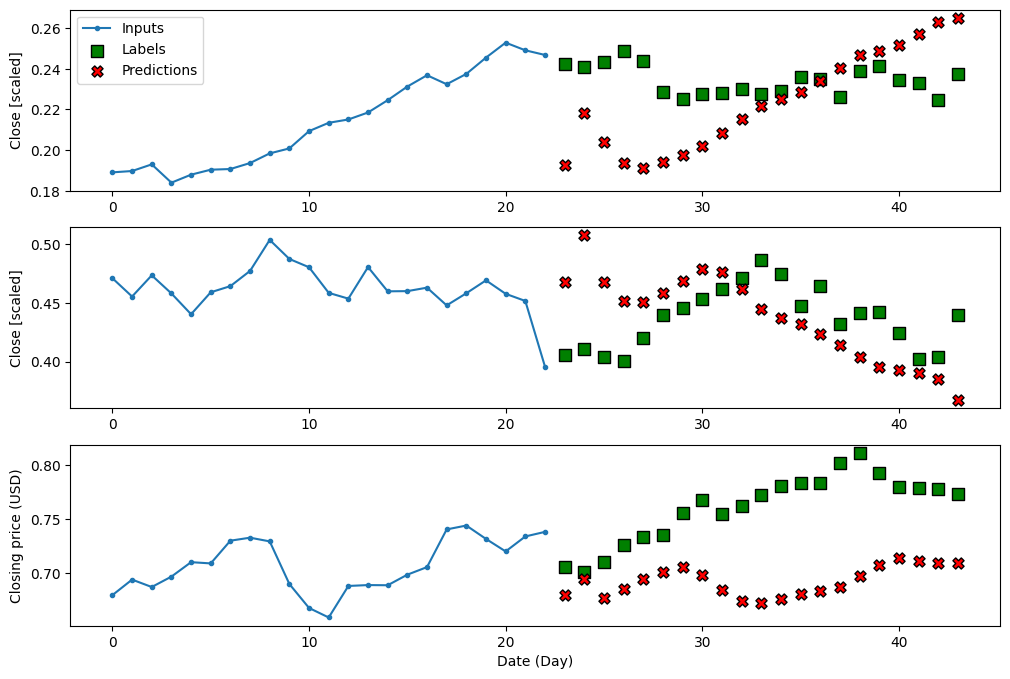

In [295]:
cnn_multi_window.plot(cnn_lstm_model)

In [296]:
class AutoRegressive(Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units)
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True)
        self.dense = Dense(train_df.shape[1])

    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)

        return prediction, state

    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)

        predictions.append(prediction)

        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)

            prediction = self.dense(x)
            predictions.append(prediction)

        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])

        return predictions

In [297]:
AR_LSTM = AutoRegressive(units=32, out_steps=21)


In [298]:

history = compile_and_fit(AR_LSTM, multi_window)

val_performance['ARLSTM'] = AR_LSTM.evaluate(multi_window.val)
performance['ARLSTM'] = AR_LSTM.evaluate(multi_window.test, verbose=0)

Epoch 1/50
93/93 [==============================] - 8s 26ms/step - loss: 0.0334 - mean_absolute_error: 0.1073 - val_loss: 0.0097 - val_mean_absolute_error: 0.0787
Epoch 2/50
93/93 [==============================] - 2s 21ms/step - loss: 0.0033 - mean_absolute_error: 0.0419 - val_loss: 0.0041 - val_mean_absolute_error: 0.0486
Epoch 3/50
93/93 [==============================] - 2s 19ms/step - loss: 0.0027 - mean_absolute_error: 0.0381 - val_loss: 0.0041 - val_mean_absolute_error: 0.0478
Epoch 4/50
93/93 [==============================] - 2s 19ms/step - loss: 0.0026 - mean_absolute_error: 0.0373 - val_loss: 0.0114 - val_mean_absolute_error: 0.0887
Epoch 5/50
93/93 [==============================] - 2s 19ms/step - loss: 0.0027 - mean_absolute_error: 0.0376 - val_loss: 0.0159 - val_mean_absolute_error: 0.1070
Epoch 6/50
26/26 [==============================] - 0s 7ms/step - loss: 0.0042 - mean_absolute_error: 0.0500


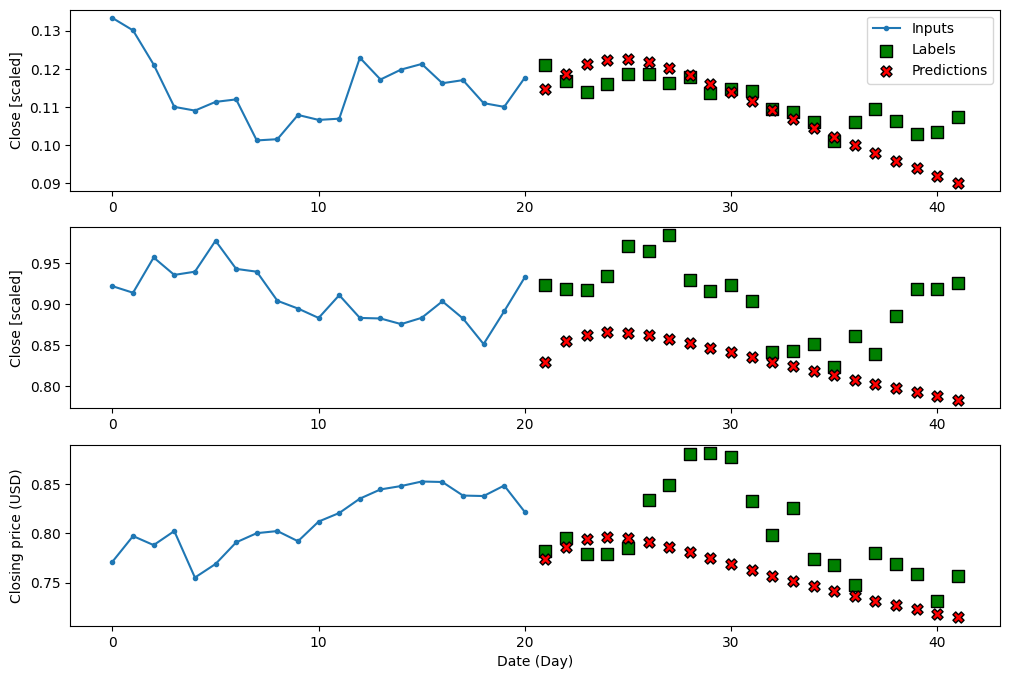

In [299]:
multi_window.plot(AR_LSTM)


In [300]:

mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

<Figure size 1000x600 with 0 Axes>

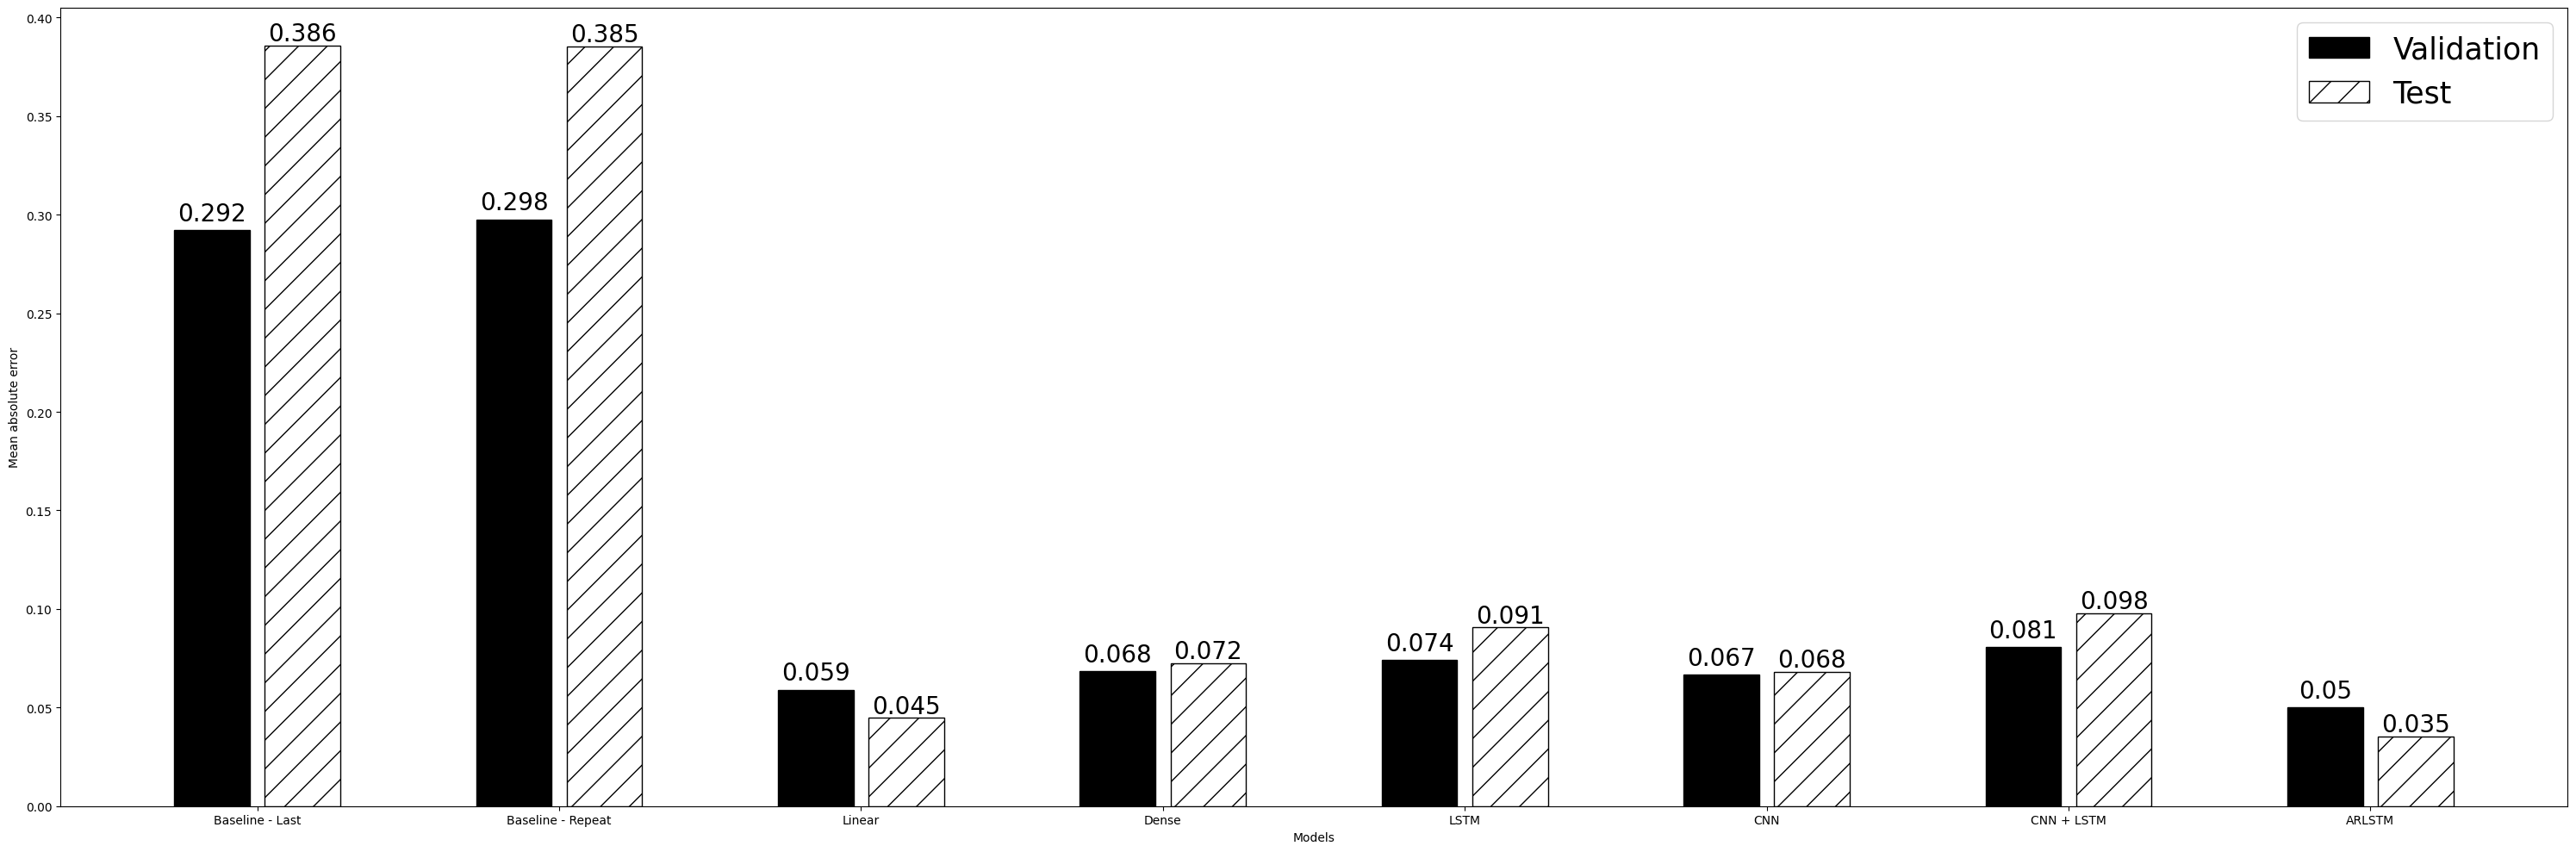

<Figure size 1000x600 with 0 Axes>

In [301]:


x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')


font_prop = font_manager.FontProperties( size=20)

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.005, s=str(round(value, 3)), ha='center',fontproperties=font_prop)

for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center',fontproperties=font_prop)

# plt.ylim(0, 0.33)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')

plt.legend(fontsize=25) # using a size in points

plt.tight_layout()
plt.figure(figsize=(10,6))


In [302]:

model_names = ['Baseline-Last', 'Baseline-Repeat', 'Linear', 'Dense', 'LSTM', 'CNN', 'LSTM+CNN', 'ARLSTM']
data = {'Test - MAE': mae_test, 'Validation - MAE': mae_val}
df = pd.DataFrame(data, index=model_names)
df_sorted = df.sort_values(by='Test - MAE', ascending=True)
df_sorted.T

,ARLSTM,Linear,CNN,Dense,LSTM,LSTM+CNN,Baseline-Repeat,Baseline-Last
Test - MAE,0.035338,0.044677,0.067982,0.072410,0.090586,0.097875,0.385195,0.385661
Validation - MAE,0.050025,0.058996,0.066651,0.068484,0.074091,0.080525,0.297669,0.292085
